# Detección de Hemorragias Intracraneales
La hemorragia en la cabeza (hemorragia intracraneal) es una afección relativamente común que tiene muchas causas que van desde traumatismo, accidente cerebrovascular, aneurisma, malformaciones vasculares, presión arterial alta, drogas ilícitas y trastornos de la coagulación sanguínea. Las consecuencias neurológicas también varían ampliamente según el tamaño, el tipo de hemorragia y la ubicación, desde el dolor de cabeza hasta la muerte. La función del radiólogo es **detectar la hemorragia, caracterizar el subtipo de hemorragia, su tamaño y determinar si la hemorragia podría estar poniendo en peligro áreas críticas del cerebro que podrían requerir cirugía inmediata.**

Si bien todas las hemorragias agudas (es decir, nuevas) parecen densas (es decir, blancas) en la tomografía computarizada (CT), las características de imagen primarias que ayudan a los radiólogos a determinar el subtipo de hemorragia son la ubicación, la forma y la proximidad a otras estructuras

<img src='./misc/subtypes-of-hemorrhage.png'></img>

Los pacientes pueden presentar más de un tipo de hemorragia cerebral, que puede aparecer en la misma imagen. Si bien las hemorragias pequeñas son menos mórbidas que las hemorragias grandes típicamente, incluso una hemorragia pequeña puede conducir a la muerte porque es un indicador de otro tipo de anomalía grave (por ejemplo, aneurisma cerebral).

**Fuente**: [RSNA Intracranial Hemorrhage Detection](https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection/overview/hemorrhage-types)

<hr  style="border-top: 1px solid #000; background: transparent;">

# ¿Podría la inteligencia artificial ser una herramienta para los radiólogos?

<img src='./misc/cnn.png'></img>

In [1]:
# torch
import torch
import torch.nn as nn
from torchvision import transforms

# local
from model.resnet import ResnetModel
from gradcam.base import GradCAM, BackPropagation, GuidedBackProp, Deconvnet
from utils import *

# Configuración
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 8

In [2]:
# Construirmos el modelo
model = ResnetModel(2)
# Cargamos los pesos del modelo entrenado
wts = torch.load('./checkpoints/best_model.pth')
model.load_state_dict(wts)

model.eval();

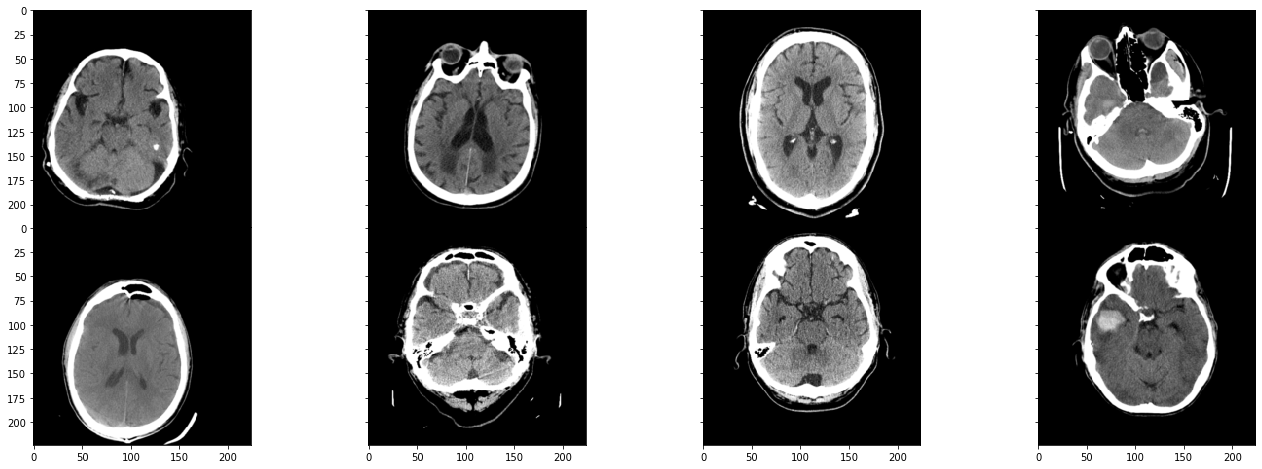

In [17]:
sample_images = load_random_samples(8)
plot_images(2, 4, sample_images)

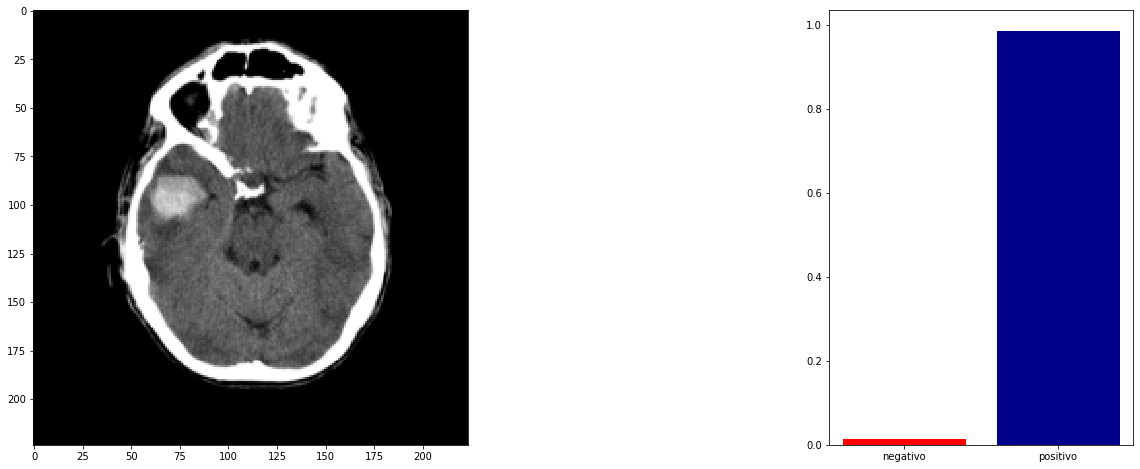

In [49]:
img = sample_images[7]

with torch.no_grad():
    outputs = model(img.view(1, *img.shape))

_, preds = torch.max(outputs, 1)

p = nn.Softmax()(outputs).squeeze()

labels = ['negativo', 'positivo']
colors = ['red', 'darkblue']
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})

a0.imshow(img.numpy()[0, ...], cmap='gray')
a1.bar (labels, p, color=colors)
plt.show()

<hr  style="border-top: 1px solid #000; background: transparent;">

## DeconvNet
Paper: [Visualizing and Understanding Convolutional Networks](https://cs.nyu.edu/~fergus/papers/zeilerECCV2014.pdf)

Se puede pensar en una DeconvNet como un modelo que usa los mismos componentes (filtering, pooling) que una ConvNet pero a la inversa, por lo que en lugar de asignar píxeles a las características, hace lo contrario.  Las DeconvNets se propusieron como una forma de realizar un aprendizaje no supervisado pero pueden usarse como una sonda de una ConvNet ya entrenada.

<img src='./misc/deconv.png' width="500"></img>


In [65]:
bp = BackPropagation(model=model)
probs, ids = bp.forward(img.view(1, 3, 224, 224)) 
bp.remove_hook()

In [66]:
deconv = Deconvnet(model=model)
_ = deconv.forward(img.view(1, *img.shape))

deconv.backward(ids=ids[:, [0]])
gradients = deconv.generate()
    
deconv.remove_hook()

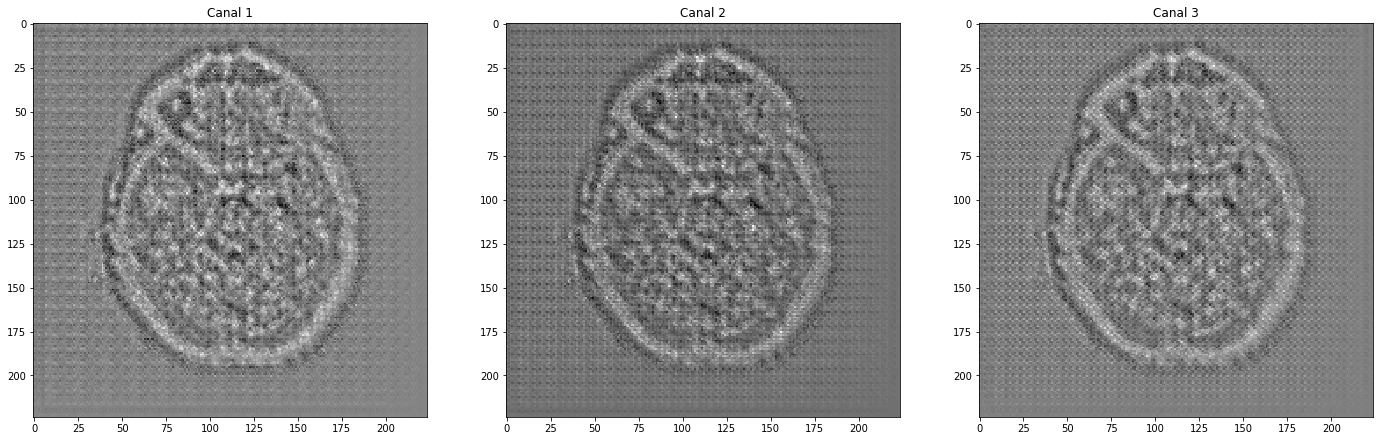

In [67]:
rcParams['figure.figsize'] = 24, 8
f, (a0, a1, a2) = plt.subplots(1, 3)
a0.title.set_text('Canal 1')
a0.imshow(gradients[0, 0, ...], cmap='gray')

a1.title.set_text('Canal 2')
a1.imshow(gradients[0, 1, ...], cmap='gray')

a2.title.set_text('Canal 3')
a2.imshow(gradients[0, 2, ...], cmap='gray')

plt.show()

<hr  style="border-top: 1px solid #000; background: transparent;">


## Grad-Cam
Paper: [Visual Explanations from Deep Networks
via Gradient-based Localization](https://arxiv.org/pdf/1610.02391.pdf)

El Gradient-weighted Class Activation Mapping (Grad-CAM), utiliza los gradientes de cualquier concepto objetivo (por ejemplo, "perro" en una red neuronal) que *fluye* hacia la capa convolucional final para producir un mapa de localización aproximado las regiones importantes de la imagen para predecir el concepto.

<img src='./misc/grad_cam.jpg'></img>


In [89]:
# Grad-CAM
gcam = GradCAM(model=model)
_ = gcam.forward(img.view(1, 3, 224, 224))

gcam.backward(ids=ids[:,[0]])
regions = gcam.generate(target_layer='backbone.layer4')

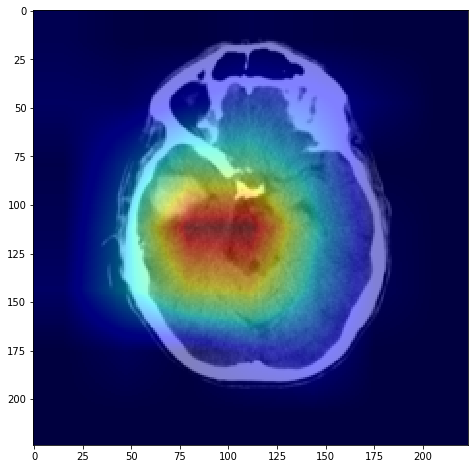

In [90]:
plt.imshow(img.numpy()[0, ...], cmap='gray')
ax = plt.imshow(regions[0, 0, ...], cmap='jet', alpha=0.5)
#plt.colorbar(ax,orientation='vertical')
plt.show()

<hr  style="border-top: 1px solid #000; background: transparent;">


## Guided BackPropagation

**Idea:** Las neuronas actúan como detectores de características particulares de la imagen.

- Solo nos interesan las características de la imagen que detecta la neurona, no el tipo de cosas que no detecta
- Entonces, al propagar el gradiente, establecemos todos los gradientes negativos en 0

In [59]:
gbp = GuidedBackProp(model=model)
_ = gbp.forward(img.view(1, 3, 224, 224))

gbp.backward(ids=ids[:, [0]])
gradients = gbp.generate()

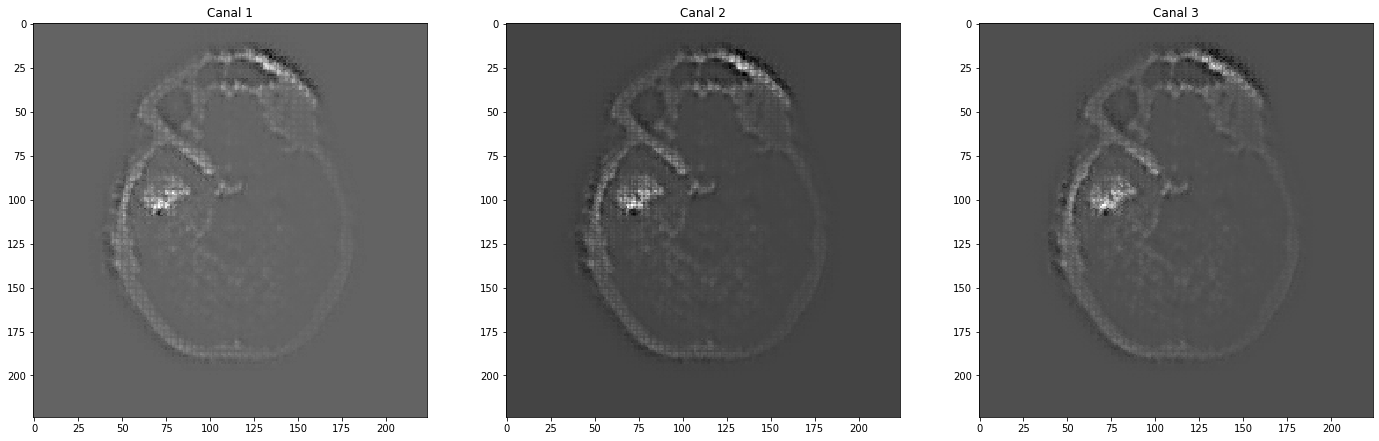

In [60]:
rcParams['figure.figsize'] = 24, 8
f, (a0, a1, a2) = plt.subplots(1, 3)
a0.title.set_text('Canal 1')
a0.imshow(gradients[0, 0, ...], cmap='gray')

a1.title.set_text('Canal 2')
a1.imshow(gradients[0, 1, ...], cmap='gray')

a2.title.set_text('Canal 3')
a2.imshow(gradients[0, 2, ...], cmap='gray')

plt.show()

<hr  style="border-top: 1px solid #000; background: transparent;">

## Guided Grad-CAM

Es posible fusionar visualizaciones de gradientes existentes con Grad-CAM para crear visualizaciones de Guided Grad-CAM que son tanto de alta resolución como discriminatorias de clases. Como resultado, las regiones importantes de la imagen que corresponden a cualquier decisión de interés se visualizan con detalles de alta resolución incluso si la imagen contiene evidencia de múltiples conceptos posibles.

<img src='./misc/grad_cam.png'></img>


In [61]:
gradient=torch.mul(regions, gradients)

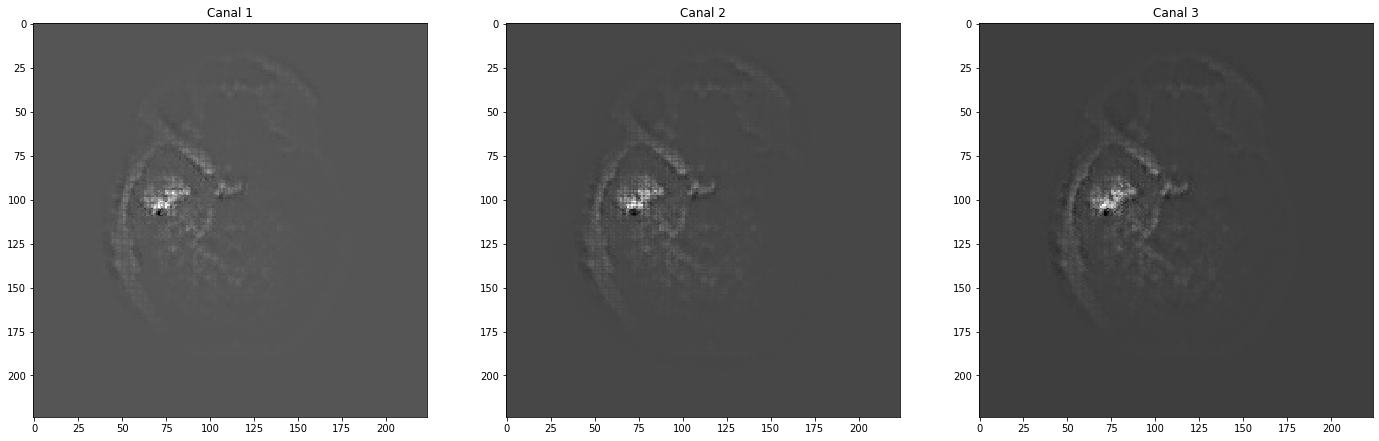

In [62]:
rcParams['figure.figsize'] = 24, 8
f, (a0, a1, a2) = plt.subplots(1, 3)
a0.title.set_text('Canal 1')
a0.imshow(gradient[0, 0, ...], cmap='gray')

a1.title.set_text('Canal 2')
a1.imshow(gradient[0, 1, ...], cmap='gray')

a2.title.set_text('Canal 3')
a2.imshow(gradient[0, 2, ...], cmap='gray')

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


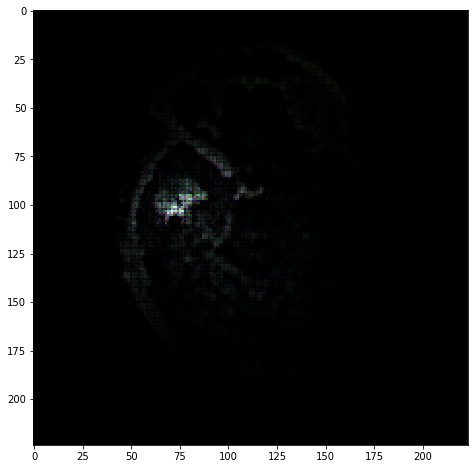

In [63]:
plt.imshow(gradient[0,...].permute(1, 2, 0), cmap='gray')
plt.show()

<hr  style="border-top: 1px solid #000; background: transparent;">

# Combinación de Ventanas

Se puede ajustar el brillo de la imagen a través del nivel una ventana aplicada y el contraste se puede ajustar a través del ancho de la ventana. Diferentes ventanas pueden resaltar diferentes características en una CT. 

<img src="./misc/windowing.png">

<img src="./misc/10_place.png">

<hr  style="border-top: 1px solid #000; background: transparent;">

## Información Espacial en Diferentes Cortes

Por la naturaleza de una CT, es de esperarse que los cambios en los cortes a diferentes niveles puedan proporcionar información sobre la presencia de anomalías.

<img src="./misc/spacial_combination.png" width="500">

<hr  style="border-top: 1px solid #000; background: transparent;">

# Modelos Secuenciales

La combinación de arquitecturas convolucionales con modelos secuenciales se ha explorado ampliamente para tareas que requieren modelar dependencias espaciales a largo plazo o dependencias temporales entre frames consecutivos, e.g. reconocimiento en vídeo. Recientemente, algunos estudios sobre imágenes biomédicas han explorado esta arquitectura para aprovechar las dependencias entre cortes en imágenes 3D.

<img src="./misc/complex_model.png"></img>

[Gold Medal Solutions RSNA Intracranial Hemorrhage Detection](https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection/discussion/117210)

<hr  style="border-top: 1px solid #000; background: transparent;">


# Interpretabilidad

- Debido a la disponibilidad de datos, de mejores algoritmos y capacidad de procesamiento muchas áreas han adoptado método que dependen de datos.
- Los modelos basados en Deep Learning han mostrado ser muy efectivos pero aún conllevan problemas que los hace *incompletos*.
- La falta de interpretabilidad y explicabilidad puede ser un inconveniente para la adopción de modelos (incluso si funcionan *bien* en la mayoría de casos), especialmente en campos como la medicina.
- Es necesario *definir* el problema de la interpretabilidad de los modelos.
- La *visualización* puede ser una capa adiciónal de los modelos que ayuda a entender y explicar el funcionamiento de los modelos.